In [ ]:
root_dir = "../../src/"


data  models  output  src


#### Install and import Python libraries

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.path.join(root_dir, 'src'))

!pip install tqdm lap
!pip install https://github.com/timmeinhardt/py-motmetrics/archive/fix_pandas_deprecating_warnings.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 7.7 MB/s 
  Created wheel for lap: filename=lap-0.4.0-cp37-cp37m-linux_x86_64.whl size=1590215 sha256=747e2206e09d92a0b5ecab6f1a064aa1fdd87c1771383e3b3d6b59d2bf692a19
  Stored in directory: /root/.cache/pip/wheels/b1/0b/e3/ef9daf1b5547b56389e42c80c3100f1e6479bf5fd00fd9d6ba
Successfully built lap
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     | 148 kB 4.5 MB/s
  Created wheel for motmetrics: filename=motmetrics-1.1.3-py3-none-any.whl size=134199 sha256=f690b41ea9cdcb907277207e7f5a4f21b5f8479a69add935c89142f61db001c0
  Stored in directory: /tmp/pip-ephem-wheel-cache-wio_d8p3/wheels/39/60/bf/90b1b02ff42db1bf7f2d2fa3eef2fe8bc46061182cf4ce7b37
Successfully built motmetrics


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.autonotebook import tqdm

import torch
from torch.utils.data import DataLoader

from tracker.data_track import MOT16Sequences
from tracker.data_obj_detect import MOT16ObjDetect
from tracker.object_detector import FRCNN_FPN
from tracker.tracker import Tracker
from tracker.utils import (plot_sequence, evaluate_mot_accums, get_mot_accum,
                           evaluate_obj_detect, obj_detect_transforms)

import motmetrics as mm
mm.lap.default_solver = 'lap'

import copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


# MOT16 dataset

The MOT16 challenge provides 7 train and 7 test video sequences with multiple objects (pedestrians) per frame. It includes many challening scenarios with camera movement, high crowdedness and object occlusions. See the [webpage](https://motchallenge.net/data/MOT16/) for video sequences with ground truth annotation.

The `MOT17Sequences` dataset class provides the possibilty to load single sequences, e.g., `seq_name = 'mot16_02'`, or the entire train/test set, e.g., `seq_name = 'mot16_train'`.


In [ ]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/train"
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/test"

MOT16-02  MOT16-04  MOT16-05  MOT16-09	MOT16-10  MOT16-11  MOT16-13
MOT16-01  MOT16-03  MOT16-06  MOT16-07	MOT16-08  MOT16-12  MOT16-14


In order to compare the tracking performance of different trackers without the effect of the object detector, the MOTChallenge provides a precomputed set of public object detections. Trackers are then evaluated on their capabilities to form tracks with the provided set. However, we want to allow you to improve on the object detections as well. Therefore, we participate in the MOT16 challenge with private detections.

## Instance segmentations

We provide the instance segmentations for the sequences `02`, `05`, `09` and `11`. These can be used for example to train a method which improves the bounding box position in occluded situations. See the original MOTS [webpage](https://www.vision.rwth-aachen.de/page/mots) for more info.

In [ ]:
from pathlib import Path

In [ ]:
data_dir = os.path.join(root_dir, 'data/MOT16/train')
list(Path(data_dir).iterdir())

[PosixPath('gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/train/MOT16-04'),
 PosixPath('gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/train/MOT16-09'),
 PosixPath('gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/train/MOT16-10'),
 PosixPath('gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/train/MOT16-05'),
 PosixPath('gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/train/MOT16-11'),
 PosixPath('gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/train/MOT16-13'),
 PosixPath('gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/train/MOT16-02')]

MOT16-02


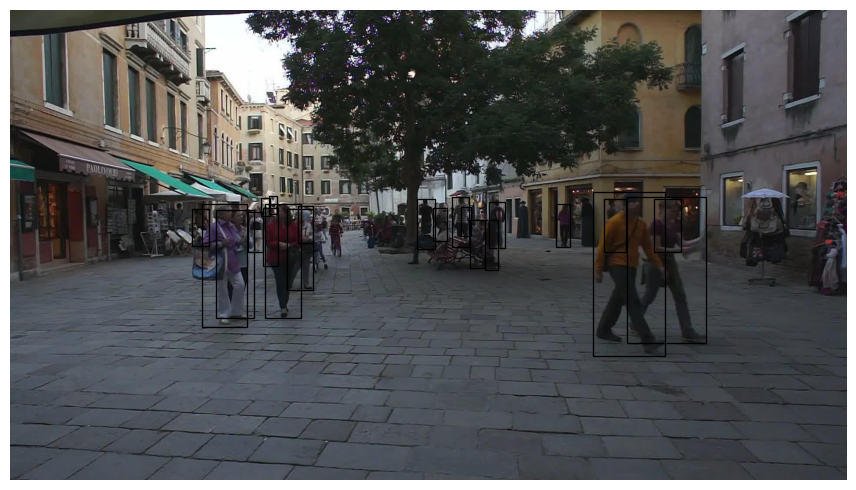

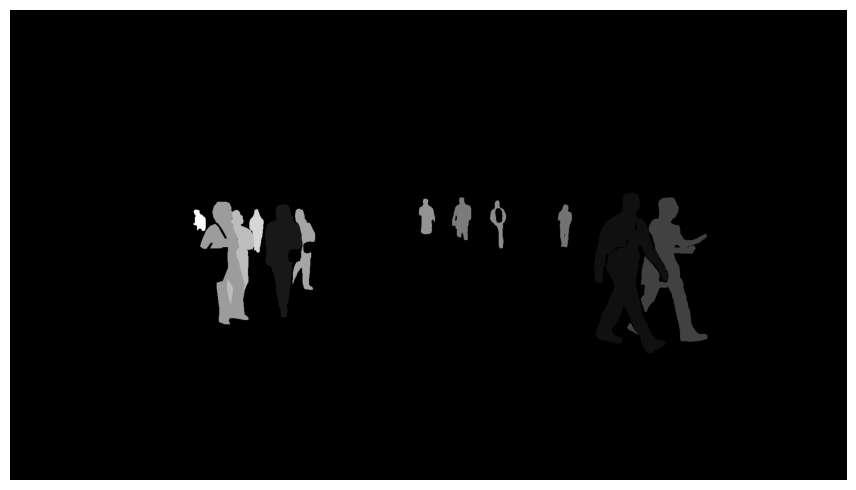

In [ ]:
seq_name = 'MOT16-02'
data_dir = os.path.join(root_dir, 'data/MOT16')
sequences = MOT16Sequences(seq_name, data_dir, load_seg=True)

for seq in sequences:
    print(seq)
    for i, frame in enumerate(seq):
        img = frame['img']
        
        dpi = 96
        fig, ax = plt.subplots(1, dpi=dpi)

        img = img.mul(255).permute(1, 2, 0).byte().numpy()
        width, height, _ = img.shape
          
        ax.imshow(img, cmap='gray')
        fig.set_size_inches(width / dpi, height / dpi)

        if 'gt' in frame:
            gt = frame['gt']
            for gt_id, box in gt.items():
                rect = plt.Rectangle(
                  (box[0], box[1]),
                  box[2] - box[0],
                  box[3] - box[1],
                  fill=False,
                  linewidth=1.0)
                ax.add_patch(rect)

        plt.axis('off')
        plt.show()

        if 'seg_img' in frame:
            seg_img = frame['seg_img']
            fig, ax = plt.subplots(1, dpi=dpi)
            fig.set_size_inches(width / dpi, height / dpi)
            ax.imshow(seg_img, cmap='gray')
            plt.axis('off')
            plt.show()
        break

# Object detector

We provide you with an object detector pretrained on the MOT challenge training set. This detector can be used and improved to generate the framewise detections necessary for the subsequent tracking and data association step.

The object detector is a [Faster R-CNN](https://arxiv.org/abs/1506.01497) with a Resnet50 feature extractor. We trained the native PyTorch implementation of Faster-RCNN. For more information check out the corresponding PyTorch [webpage](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

In [ ]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/models"

faster_rcnn_fpn.model



## Configuration

In [ ]:
obj_detect_model_file = os.path.join(root_dir, 'models/faster_rcnn_fpn.model')
obj_detect_nms_thresh = 0.3

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# object detector
obj_detect = FRCNN_FPN(num_classes=2, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(obj_detect_model_file,
                                   map_location=lambda storage, loc: storage)
obj_detect.load_state_dict(obj_detect_state_dict)
obj_detect.eval()
obj_detect = obj_detect.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'backbone_name' and 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


If you uncomment und run the following evaluation of the object detection training set, you should obtain the following evaluation result:  
`AP: 0.878304423893276 Prec: 0.9225370296471914 Rec: 0.9166948510117208 TP: 78602.0 FP: 6600.0
`

In [ ]:
dataset_test = MOT16ObjDetect(os.path.join(root_dir, 'data/MOT16/train'),
                              obj_detect_transforms(train=False))
def collate_fn(batch):
    return tuple(zip(*batch))
data_loader_test = DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

# evaluate_obj_detect(obj_detect, data_loader_test) # <-- takes a while.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
imgs,targets = next(iter(data_loader_test))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(f'num obj in batch = {len(imgs)}')
print(f'img tensor size = {imgs[0].shape}')
print(f'num obj in targets = {len(targets)}')

print(f'targets keys = {targets[0].keys()}')
targets

num obj in batch = 1
img tensor size = torch.Size([3, 1080, 1920])
num obj in targets = 1
targets keys = dict_keys(['boxes', 'labels', 'image_id', 'area', 'iscrowd', 'visibilities'])


({'area': tensor([24480., 18802., 20500., 15900., 15939., 24750., 10266., 11712.,  7488.,
          11700., 11269.,  9900., 14378., 12524., 12980., 10203.,  7520.,  5490.,
           5520.,  9180.,  7650.,  8424.,  4251.,  4716., 17040., 15573.,  8772.,
           8964.,  6640.,  7680.,  9078.,  7084.,  8788.,  8352.,  7335.,  9845.,
           7339.,  9114.]), 'boxes': tensor([[1362.,  568., 1464.,  808.],
          [ 370.,  409.,  449.,  647.],
          [ 102.,  548.,  184.,  798.],
          [1733.,  456., 1808.,  668.],
          [1097.,  979., 1174., 1186.],
          [ 631.,  760.,  730., 1010.],
          [ 795.,  148.,  854.,  322.],
          [1788.,  205., 1852.,  388.],
          [1486.,   70., 1538.,  214.],
          [1635.,  264., 1700.,  444.],
          [1556.,  253., 1615.,  444.],
          [1103.,  211., 1158.,  391.],
          [1030.,  132., 1109.,  314.],
          [ 227.,  400.,  289.,  602.],
          [ 263.,  364.,  322.,  584.],
          [ 871.,  121.,  928

In [ ]:
device = list(obj_detect.parameters())[0].device
imgs = [img.to(device) for img in imgs]
obj_detect.eval()
with torch.no_grad():
    preds = obj_detect(imgs)

In [ ]:
preds

[{'boxes': tensor([[ 629.7157,  759.3956,  727.6976, 1011.3059],
          [ 101.3200,  547.0130,  183.0036,  795.1958],
          [1359.3799,  566.3056, 1462.7910,  807.9976],
          [ 371.5735,  408.6487,  451.1308,  649.5993],
          [1731.1742,  456.6656, 1805.4696,  670.1862],
          [ 794.3857,  146.1472,  853.4858,  318.8245],
          [ 414.1839,   89.9557,  467.7229,  261.4570],
          [ 702.8549,    0.0000,  754.8684,  154.6473],
          [1486.5245,   69.5517, 1538.4253,  213.5581],
          [1789.4915,  204.8671, 1852.9355,  392.0151],
          [1029.8988,  131.6327, 1107.4589,  310.9258],
          [1636.8094,  261.9354, 1697.2117,  443.5483],
          [ 510.8496,  146.9739,  605.7568,  324.6604],
          [ 460.8187,   82.6262,  513.0288,  252.0899],
          [ 226.9525,  400.7046,  287.3082,  593.9865],
          [ 220.2328,  125.1391,  266.4613,  289.6745],
          [1102.4537,  209.4555, 1161.6182,  389.7509],
          [ 355.7546,  100.6815,  407.2

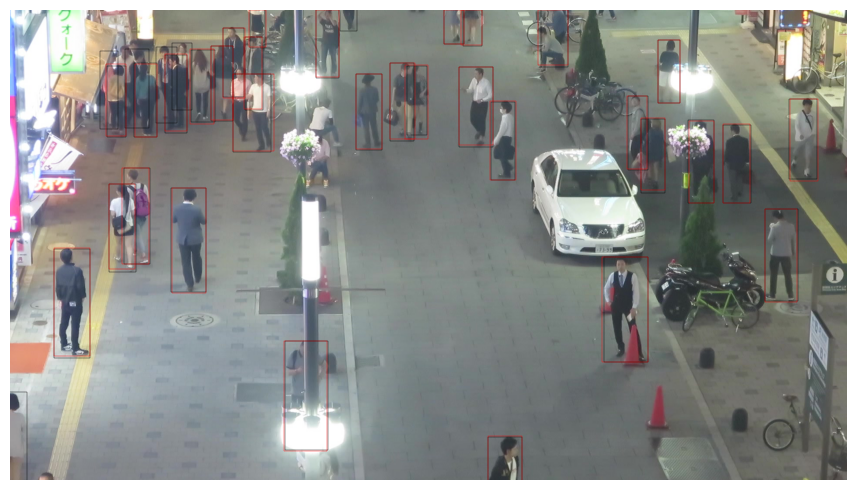

In [ ]:

img = imgs[0].cpu()

dpi = 96
fig, ax = plt.subplots(1, dpi=dpi)

img = img.mul(255).permute(1, 2, 0).byte().numpy()
width, height, _ = img.shape
  
ax.imshow(img, cmap='gray')
fig.set_size_inches(width / dpi, height / dpi)

gt = targets[0]
for box in gt['boxes']:
    rect = plt.Rectangle(
      (box[0], box[1]),
      box[2] - box[0],
      box[3] - box[1],
      fill=False,
      linewidth=0.3,color='black')
    ax.add_patch(rect)

for box in preds[0]['boxes'].cpu().numpy():
    rect = plt.Rectangle(
      (box[0], box[1]),
      box[2] - box[0],
      box[3] - box[1],
      fill=False,
      linewidth=0.3,color='red')
    ax.add_patch(rect)

plt.axis('off')
plt.show()


In [ ]:
# black - GT, red- predicted, as where are several FN (no detected) pedestrials in  top-left corner 
# lets change obj_detect_nms_thresh to add more detections
obj_detect_nms_thresh = 0.8


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# object detector
obj_detect = FRCNN_FPN(num_classes=2, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(obj_detect_model_file,
                                   map_location=lambda storage, loc: storage)
obj_detect.load_state_dict(obj_detect_state_dict)
obj_detect.eval()
obj_detect = obj_detect.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'backbone_name' and 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
device = list(obj_detect.parameters())[0].device
imgs = [img.to(device) for img in imgs]
obj_detect.eval()
with torch.no_grad():
    preds = obj_detect(imgs)

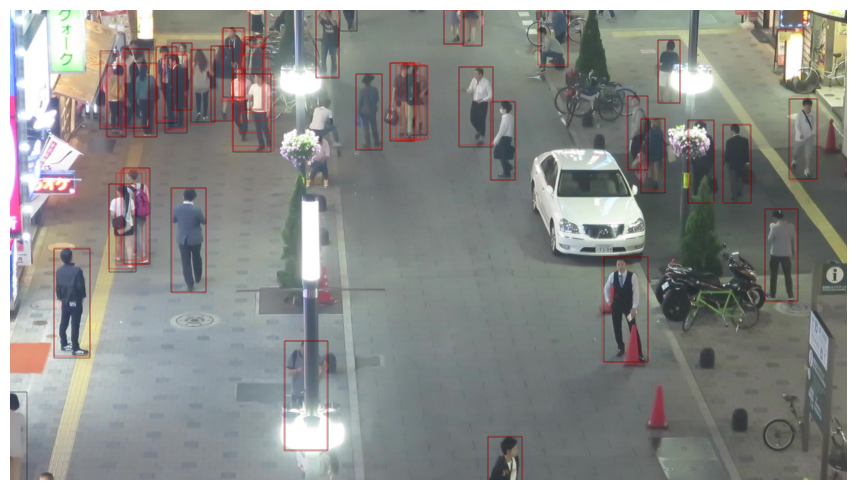

In [ ]:

img = imgs[0].cpu()

dpi = 96
fig, ax = plt.subplots(1, dpi=dpi)

img = img.mul(255).permute(1, 2, 0).byte().numpy()
width, height, _ = img.shape
  
ax.imshow(img, cmap='gray')
fig.set_size_inches(width / dpi, height / dpi)

gt = targets[0]
for box in gt['boxes']:
    rect = plt.Rectangle(
      (box[0], box[1]),
      box[2] - box[0],
      box[3] - box[1],
      fill=False,
      linewidth=0.3,color='black')
    ax.add_patch(rect)

for box in preds[0]['boxes'].cpu().numpy():
    rect = plt.Rectangle(
      (box[0], box[1]),
      box[2] - box[0],
      box[3] - box[1],
      fill=False,
      linewidth=0.3,color='red')
    ax.add_patch(rect)

plt.axis('off')
plt.show()

In [ ]:
# as a result change obj_detect_nms_thresh 0.3->0.8 add more TP detections, but more FP